<a href="https://colab.research.google.com/github/TeamMAMI/MAMI/blob/main/Baselines/image_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate baseline for image only data

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
#pip install -r requirements.txt
'''
#requires the same folder:
- script evaluation
-folder 'ref' with truth.txt
-folder 'TRAINING' with images
'''

# import evaluation
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
import os
import gc
import shutil 


In [3]:
# path
csv_path_test = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Temporary/test.csv'
csv_path_train = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Temporary/train.csv'
image_path = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Images'

def loadImage(image_path):
    try:
        return load_img(image_path, target_size=(image_size, image_size))
    except:
        image_path = image_path.replace('png', 'jpg')
        return load_img(image_path, target_size=(image_size, image_size))

if not os.path.exists('./ImageModel'):
    os.makedirs('./ImageModel')

In [4]:
batch_size = 32
epochs = 50
image_size = 224
threshold = 0.5

tf.compat.v1.disable_eager_execution()

In [6]:
#_______________________________Load Train Data_______________________________

train_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'])
path = image_path+'/'
train_df['image_path'] = path + train_df['file_name']

#load images
train_df['image'] = None
train_df['image'] = train_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
X_train = train_df[['file_name', 'image']]
y_train = train_df['misogynous']

#images
tmp = []
for value in X_train['image']:
  tmp.append(value) 
iX_train = np.array(tmp)

#misogynous label
tmp = []
for value in y_train:
    tmp.append([value])  
y_train = np.array(tmp)

#clear memory
del train_df

gc.collect()


0

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6300/6300 [==============================] - 31s 5ms/sample - loss: 4.3635 - accuracy: 0.5844 - val_loss: 0.8412 - val_accuracy: 0.6529
Epoch 2/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 1.0031 - accuracy: 0.6106 - val_loss: 0.7653 - val_accuracy: 0.6314
Epoch 3/50
6300/6300 [==============================] - 15s 2ms/sample - loss: 0.8466 - accuracy: 0.6190 - val_loss: 0.6752 - val_accuracy: 0.6129
Epoch 4/50
6300/6300 [==============================] - 15s 2ms/sample - loss: 0.7193 - accuracy: 0.6376 - val_loss: 0.6384 - val_accuracy: 0.6600
Epoch 5/50
6300/6300 [==============================] - 15s 2ms/sample - loss: 0.6488 - accuracy: 0.6457 - val_loss: 0.6492 - val_accuracy: 0.6614
Epoch 6/50
6300/6300 [==============================] - 15s 2ms/sample - loss: 0.5943 - accuracy: 0.6719 - val_loss: 0.6720 - val_accuracy: 0.6743
Epoch 7/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 0.5911 - accuracy: 0.6817 - val_loss: 0.6078 - val

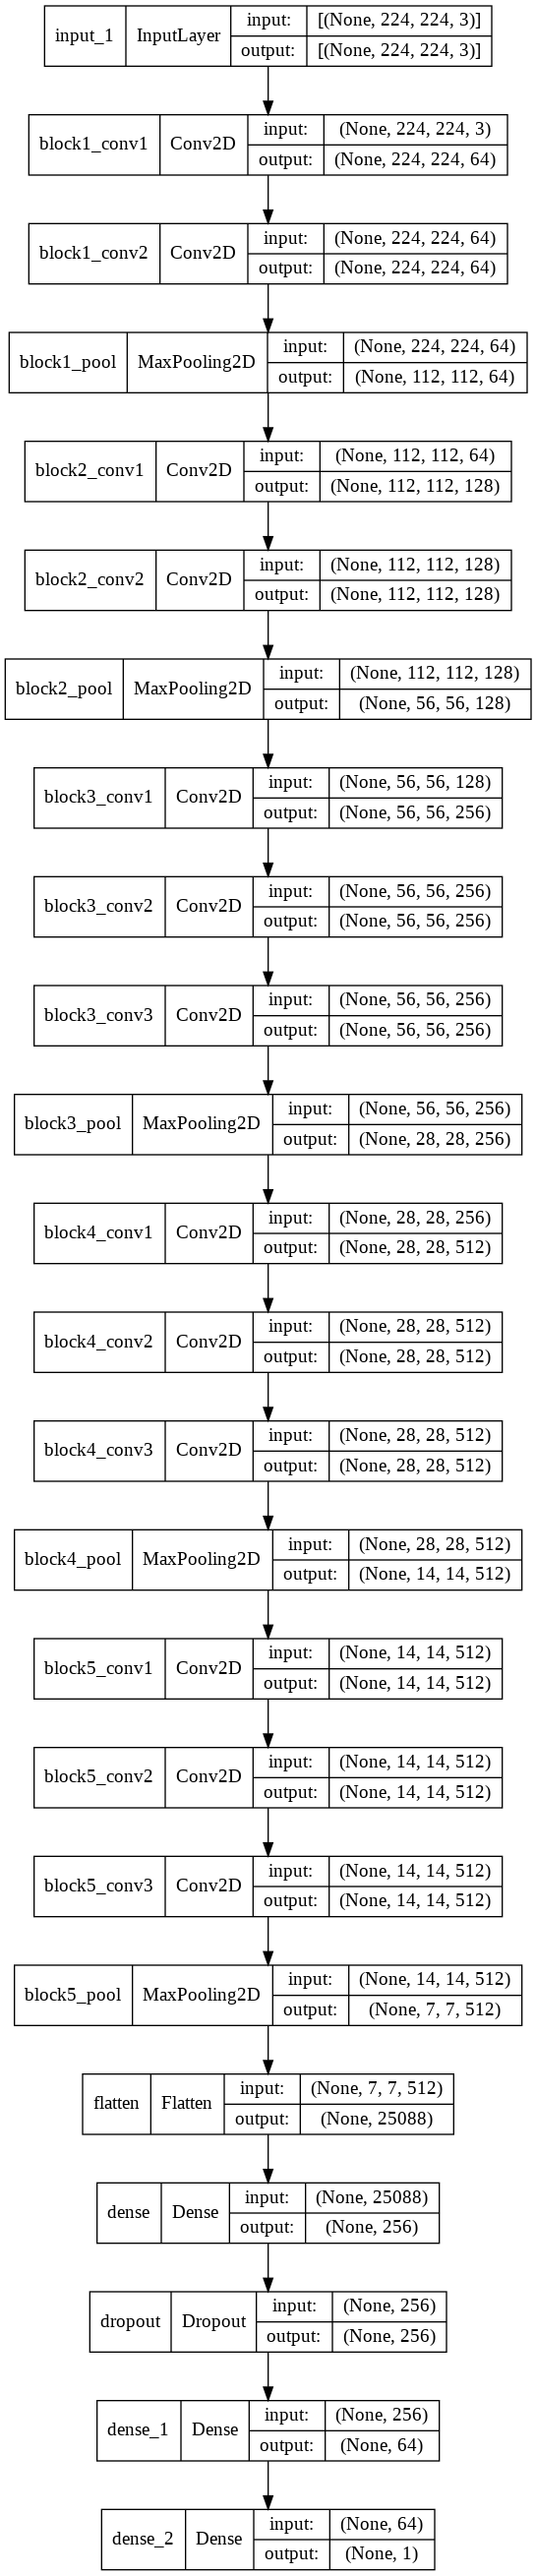

In [7]:

#_______________________________IMAGE MODEL_______________________________
l2_strength = 1e-5

input_image = layers.Input(shape=(image_size,image_size,3))
vgg_model = VGG16(input_tensor = input_image, weights = 'imagenet', include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = layers.Flatten(input_shape=vgg_model.output_shape[1:])(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dense(1, activation='sigmoid')(x)
image_model = Model(vgg_model.input, x)

image_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
image_model.summary()

history = image_model.fit(iX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= epochs,
                    batch_size=batch_size,
                    #verbose=0,
                    )
                    
image_model.save('ImageModel/model_image.h5')
tf.keras.utils.plot_model(image_model, "./ImageModel/model_image.png", show_shapes=True)


In [10]:

#_______________________________Load Test Data_______________________________
#clear memory
# del X_train
# del y_train
# del iX_train

gc.collect()

#load data
test_df = pd.read_csv(csv_path_test)
path = image_path+'/'
test_df['image_path'] = path + test_df['file_name']

#Load images
test_df['image'] = None
test_df['image'] = test_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
#images
tmp = []
for value in test_df['image']:
    tmp.append(value)  
iX_test = np.array(tmp)


In [11]:

#_______________________________PREDICTION_______________________________
predictions = image_model.predict(iX_test, batch_size=batch_size)
predictions = predictions.reshape(predictions.shape[0])
pred = predictions > threshold
pred = list(map(int, pred)) #true/false to 1/0

predictions_db = pd.DataFrame(data=test_df['file_name'])
predictions_db['misogynist'] = pred


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:

# #_______________________________EVALUATION_______________________________
# if not os.path.exists('./res'):
#     os.makedirs('./res')

# predictions_db.to_csv('./res/answer.txt', index=False, sep='\t', header=False)  
# evaluation.main(['','./', './ImageModel'])
# #move res folder to ImageModel folder
# shutil.move('./res/', './ImageModel')


In [13]:
from sklearn.metrics import f1_score

f1_score(test_df['misogynous'], predictions_db['misogynist'], average='micro')

0.664